In [1]:
from setup_env import setup_environment

setup_environment()

In [33]:
import numpy as np
import pandas as pd

from project.wfc.factory import Factory
from project.wfc.grid import Grid, Rect
from project.wfc.judge import Judge
from project.config import DATA_SOURCE
from project.wfc.wfc import WFC
from project.wfc.judge import RandomJudge
from project.machine_learning.model_mc import ModelMC
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
factory = Factory(DATA_SOURCE)
patterns = factory.create_patterns()

INFO - Validation Result: success



In [27]:
def evaluate_wfc(
    sizes: np.ndarray, target_successes: int, judge: Judge, name: str
) -> pd.DataFrame:
    results = []

    for size in tqdm(sizes):
        rect = Rect(width=size, height=size)
        grid = Grid(rect=rect, patterns=patterns)
        wfc = WFC(grid=grid, judge=judge)

        successes = 0
        tries = 0

        while successes < target_successes:
            is_succeeded = False

            while not is_succeeded:
                tries += 1
                is_succeeded = wfc.generate()

            successes += 1

        mean_tries = tries / target_successes
        results.append({"model": name, "size": size**2, "mean_tries": mean_tries})

    return pd.DataFrame(results)

In [28]:
sizes = np.arange(2, 11)
target_successes = 100

In [29]:
random_judge = RandomJudge()

wfc_df = evaluate_wfc(sizes, target_successes, random_judge, "wfc")

wfc_df.head(5)

100%|██████████| 9/9 [00:22<00:00,  2.50s/it]


,model,size,mean_tries
0,wfc,4,1.00
1,wfc,9,1.09
2,wfc,16,1.22
3,wfc,25,1.49
4,wfc,36,1.74


In [30]:
mc_judge = ModelMC(view=Rect(3, 3))
mc_judge.load_weights("data/weights/wfcwmc/mmc_1000")

wfcwmc_df = evaluate_wfc(sizes, target_successes, mc_judge, "wfcwmc")

wfcwmc_df.head(5)

100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


,model,size,mean_tries
0,wfcwmc,4,1.00
1,wfcwmc,9,1.02
2,wfcwmc,16,1.02
3,wfcwmc,25,1.04
4,wfcwmc,36,1.13


In [31]:
evaluation_df = pd.concat([wfc_df, wfcwmc_df]).reset_index(drop=True)

<Axes: xlabel='size', ylabel='mean_tries'>

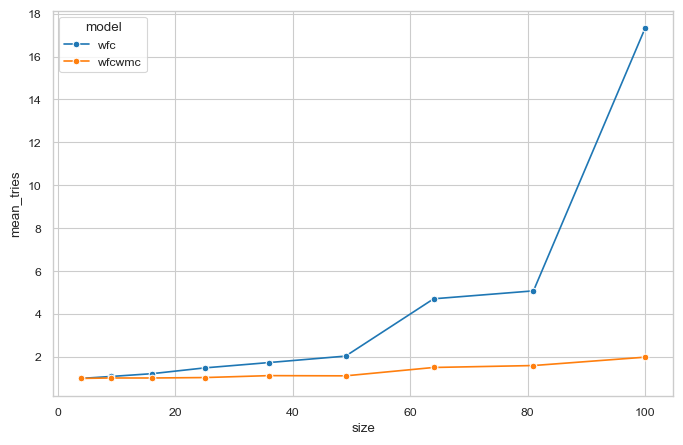

In [38]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=evaluation_df, x="size", y="mean_tries", hue="model", marker="o")